 <p style="padding-top:10px; text-align: center; font-size: 24pt">Yet Another Tutorial on</p>
 <p style="padding-bottom:10px; text-align: center; font-size: 32pt">Variational Autoencoders</p>
 
 # Introduction
Variational autoencoders (VAEs) are one of the most popular and widely-used generative models. Along the data distribution, it also learns the space of latent factors making it suitable for downstream tasks like classification and out-of-distribution detection. In this notebook, we introduct the basics of VAEs alongside an example PyTorch implementation.
 

In [1]:
from abc import ABC, abstractmethod
from typing import Tuple
from enum import Enum

import math
import numpy as np
import torch
import torchvision

import matplotlib.pyplot as plt

device = torch.device('cuda:0')

/home/jnemeth/mySandbox/venv-pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Variational Autoencoders
What VAEs are basically doing is learning to model the data and latent distributions using a given empirical data distribution (training dataset). In the simpliest case, the latent variables can be modelled by a normal distribution. The data distributions, in our examples, will be modelled Bernoulli and normal distributions for binary and color images, respectively. The following functions are used to compute the log-density functions of these distributions.

In [2]:
class DataModel(Enum):
    BERNOULLI = 1
    NORMAL = 2

def log_bernoulli_pdf(target: torch.Tensor, prob: torch.Tensor) -> torch.Tensor:
    return -torch.nn.functional.binary_cross_entropy(prob, target, reduction="none")

LOG_2PI = 1.83736998048

def log_normal_pdf(x: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
    return -0.5 * ((x - mu) ** 2 * torch.exp(-logvar) + logvar + LOG_2PI)

def log_standard_normal_pdf(x: torch.Tensor) -> torch.Tensor:
    return -0.5 * (x ** 2 + LOG_2PI)

In general, our goal is to approximate the data distribution $p_D({\mathbf x})$ using a parameterized model $p_\theta({\mathbf x})$. We will use neural networks to represent $p_\theta$, thus $\theta$ is nothing else but the vector of its weights. We looking for a maximum (log-)likelihood estimation of $\theta$, that is, given a set of training samples $\{{\mathbf x}_i | i=1\dots n, {\mathbf x}_i \sim p_D\}$ we seek for 

$$
\text{argmax}_\theta \prod_{i=1}^{n} p_\theta({\mathbf x}_i)=
\text{argmax}_\theta \log\prod_{i=1}^{n} p_\theta({\mathbf x}_i)=
\text{argmax}_\theta \sum_{i=1}^{n} \log p_\theta({\mathbf x}_i)
$$

VAEs approach this by learning a generative model $p_\theta({\mathbf x},{\mathbf z})$, that is a joint distribution of data points and latent variables. Latent variables can be thought of as the underlying generative factors of the data. For example, in the case of images such factors can be the object on the image, its size, orientation, color, background color, etc. In general, VAEs does not learn such explainable factors, instead ${\mathbf z}$ can also be considered as a compressed representation of ${\mathbf x}$.

The difficulty at this point comes from the fact that we can't optimize $p_\theta({\mathbf x}) = \int_z p_\theta({\mathbf x}|{\mathbf z})p_\theta({\mathbf z})\,dz$ directly as this integral is intractable

In [3]:
class VAE(ABC):
    def __init__(self, data_model: DataModel, z_dim: int):
        self.data_model = data_model
        self.z_dim = z_dim

    def elbo(self, x: torch.Tensor):
        z_mu, z_logvar = self.encode(x)
        z = self.reparameterization(z_mu, z_logvar)


        if self.data_model == DataModel.BERNOULLI:
            x_prob = self.decode(z)
            log_px_z = log_bernoulli_pdf(x, x_prob).flatten(1).sum(1)
        elif self.data_model == DataModel.NORMAL:
            x_mu, x_logvar = self.decode(z)
            log_px_z = log_normal_pdf(x, x_mu, x_logvar).flatten(1).sum(1)
        else:
            raise RuntimeError("Unknown data model!")


        log_pz = log_standard_normal_pdf(z).sum(1)
        log_qz_x = log_normal_pdf(z, z_mu, z_logvar).sum(1)

        return log_px_z + log_pz - log_qz_x

    def get_z_dim(self):
        return self.z_dim

    @staticmethod
    def reparameterization(mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        eps = torch.randn(size=mu.shape, device=mu.get_device())
        return mu + eps * (0.5*logvar).exp()


    @abstractmethod
    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        raise NotImplemented

    @abstractmethod
    def decode(self, z: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        raise NotImplemented


In [4]:
class SimpleVAE(torch.nn.Module, VAE):
    def __init__(self, data_model: DataModel, data_shape: Tuple[int], z_dim: int):
        torch.nn.Module.__init__(self)
        VAE.__init__(self, data_model, z_dim)

        self.data_shape = data_shape
        data_dim = math.prod(data_shape)
        num_data_params = 2 if self.data_model == DataModel.NORMAL else 1

        self.enc = torch.nn.Sequential(
            torch.nn.Linear(data_dim, 512),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Linear(512, 512),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Linear(512, 2*z_dim)
        )
        self.dec = torch.nn.Sequential(
            torch.nn.Linear(z_dim, 512),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Linear(512, 512),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Linear(512, num_data_params*data_dim)
        )

    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x = x.flatten(1) - 0.5
        z = self.enc(x)
        mu, lv = torch.chunk(z, 2, dim=1)
        return mu, lv


    def decode(self, z: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x = self.dec(z)

        if self.data_model == DataModel.NORMAL:
            mu, lv = torch.chunk(x, 2, dim=1)
            mu = torch.sigmoid(mu)
            mu = mu.reshape((mu.shape[0],)+self.data_shape)
            lv = lv.reshape((lv.shape[0],)+self.data_shape)
            return mu, lv
        else:
            prob = torch.sigmoid(x)
            prob = prob.reshape((prob.shape[0],)+self.data_shape)
            return prob

# TRAIN

In [5]:
def train(model: VAE,
          dataset: torch.utils.data.Dataset,
          epochs:int ,
          batch_size: int,
          num_workers: int):

    loader = torch.utils.data.DataLoader(dataset,
                                         batch_size=batch_size,
                                         drop_last=True,
                                         shuffle=True,
                                         num_workers=num_workers,
                                         pin_memory=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for i in range(epochs):
        model.train()
        sum_elbo = 0
        for x, _ in loader:
            x = x.to(device)

            optimizer.zero_grad(set_to_none=True)

            elbo = model.elbo(x)
            loss = (-elbo).mean()

            loss.backward()
            optimizer.step()

            sum_elbo += elbo.mean().item()

        mean_elbo = sum_elbo / len(loader)
        print(f"epoch: {i:02d}/{epochs}, elbo: {mean_elbo:.2f}")

# MNIST


In [7]:
dataset_mnist = torchvision.datasets.MNIST('../datasets/mnist/',
                                           download=True,
                                           train=True,
                                           transform=torchvision.transforms.Compose([
                                               torchvision.transforms.ToTensor(),
                                               lambda x: (x>0.5).float()
                                            ]))
vae_mnist = SimpleVAE(DataModel.BERNOULLI, data_shape=(1, 28, 28), z_dim=2).to(device)
train(vae_mnist, dataset_mnist, epochs=40, batch_size=64, num_workers=4)

epoch: 00/40, elbo: -168.93
epoch: 01/40, elbo: -153.19
epoch: 02/40, elbo: -148.51
epoch: 03/40, elbo: -146.07
epoch: 04/40, elbo: -144.31
epoch: 05/40, elbo: -143.41
epoch: 06/40, elbo: -142.19
epoch: 07/40, elbo: -141.50
epoch: 08/40, elbo: -140.91
epoch: 09/40, elbo: -140.36
epoch: 10/40, elbo: -139.76
epoch: 11/40, elbo: -139.41
epoch: 12/40, elbo: -138.92
epoch: 13/40, elbo: -138.57
epoch: 14/40, elbo: -138.07
epoch: 15/40, elbo: -137.91
epoch: 16/40, elbo: -137.54
epoch: 17/40, elbo: -137.14
epoch: 18/40, elbo: -137.00
epoch: 19/40, elbo: -136.84
epoch: 20/40, elbo: -136.45
epoch: 21/40, elbo: -136.41
epoch: 22/40, elbo: -135.93
epoch: 23/40, elbo: -135.68
epoch: 24/40, elbo: -135.70
epoch: 25/40, elbo: -135.44
epoch: 26/40, elbo: -135.16
epoch: 27/40, elbo: -134.91
epoch: 28/40, elbo: -134.86
epoch: 29/40, elbo: -134.82
epoch: 30/40, elbo: -134.61
epoch: 31/40, elbo: -134.41
epoch: 32/40, elbo: -134.32
epoch: 33/40, elbo: -134.16
epoch: 34/40, elbo: -133.96
epoch: 35/40, elbo: 

# Inspect the Model

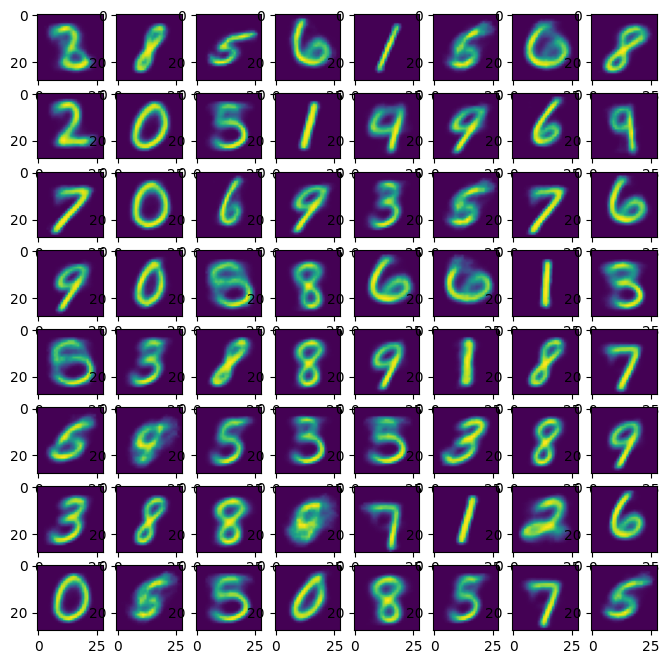

In [8]:
def plot_image_grid(images: torch.Tensor, rows: int, cols: int):
    assert images.shape[0] == rows*cols
    images = torch.clamp(images, 0.0, 1.0)
    images = torch.permute(images, (0, 2, 3, 1))
    images = images.cpu().detach().numpy()

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(8,8))

    for i in range(rows):
        for j in range(cols):
            image = images[j+i*cols]

            axes[i, j].imshow(image)
    plt.show()

def plot_image_samples(model: VAE):
    rows, cols = 8, 8

    model.eval()
    z_sample = torch.randn(size=(rows*cols, model.get_z_dim()), device=device)

    images = model.decode(z_sample)
    if isinstance(images, tuple):
        images = images[0]

    plot_image_grid(images, rows, cols)

plot_image_samples(vae_mnist)

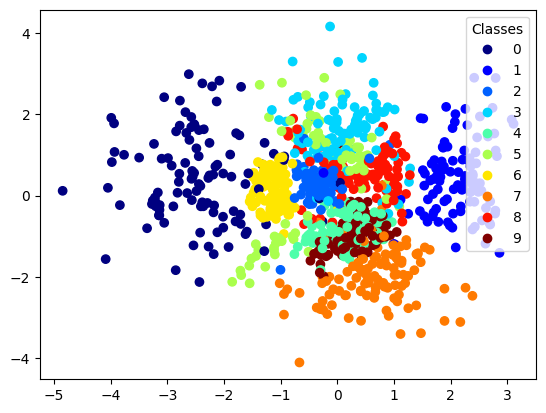

In [9]:
def plot_latent_samples(model: VAE, dataset: torch.utils.data.Dataset, max_samples: int=1000):
    model.eval()

    loader = torch.utils.data.DataLoader(dataset,
                                         batch_size=32,
                                         drop_last=True,
                                         shuffle=True,
                                         num_workers=4,
                                         pin_memory=True)

    x = []
    y = []
    c = []

    num_samples = 0
    for img, labels in loader:
        img = img.to(device)
        z_mu, z_logvar = model.encode(img)

        z = model.reparameterization(z_mu, z_logvar)
        z = z.detach().cpu().numpy()

        x.append(z[:, 0])
        y.append(z[:, 1])
        c.append(labels)

        num_samples += img.shape[0]
        if num_samples > max_samples:
            break

    x = np.concatenate(x, 0)
    y = np.concatenate(y, 0)
    c = np.concatenate(c, 0)

    scatter = plt.scatter(x, y, c=c, cmap="jet")
    plt.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
    plt.show()

plot_latent_samples(vae_mnist, dataset_mnist)

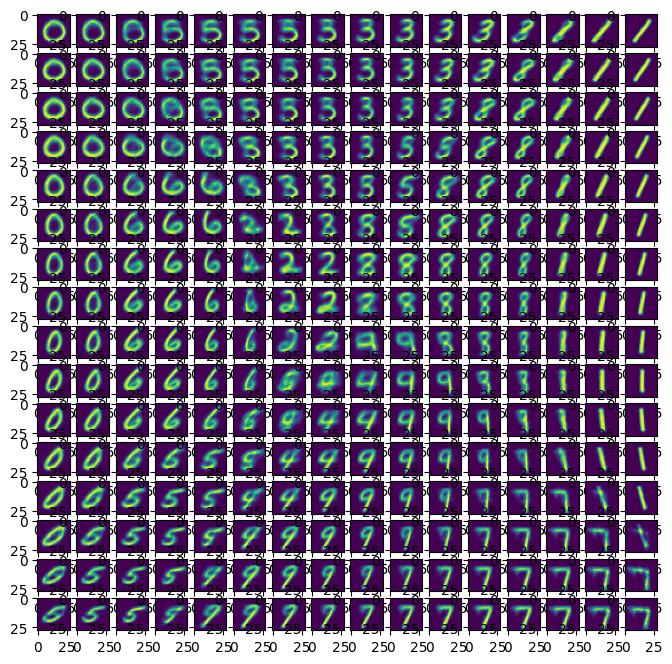

In [10]:
def plot_data_distribution(model: torch.nn.Module):
    steps = 16
    xs = torch.linspace(-2.0, 2.0, steps=steps)
    ys = torch.linspace(2.0, -2.0, steps=steps)
    x, y = torch.meshgrid(xs, ys, indexing='xy')

    z = torch.stack([x.flatten(), y.flatten()], dim=1)
    z = z.to(device)

    images = model.decode(z)
    if isinstance(images, tuple):
        images = images[0]

    plot_image_grid(images, steps, steps)

plot_data_distribution(vae_mnist)

# COLOR

In [ ]:
"""
dataset_svhn = torchvision.datasets.SVHN('svhn/', download=True,  split='train',
                                         transform=torchvision.transforms.ToTensor())

vae_svhn = SimpleVAE(DataModel.NORMAL, data_shape=(3, 32, 32), z_dim=16).to(device)
train(vae, dataset_svhn, epochs=20, batch_size=64, num_workers=4)
plot_image_samples(vae_svhn)
"""